In [1]:
ticker = "MSFT"

In [2]:
# Parameters
ticker = "EURUSD=X"


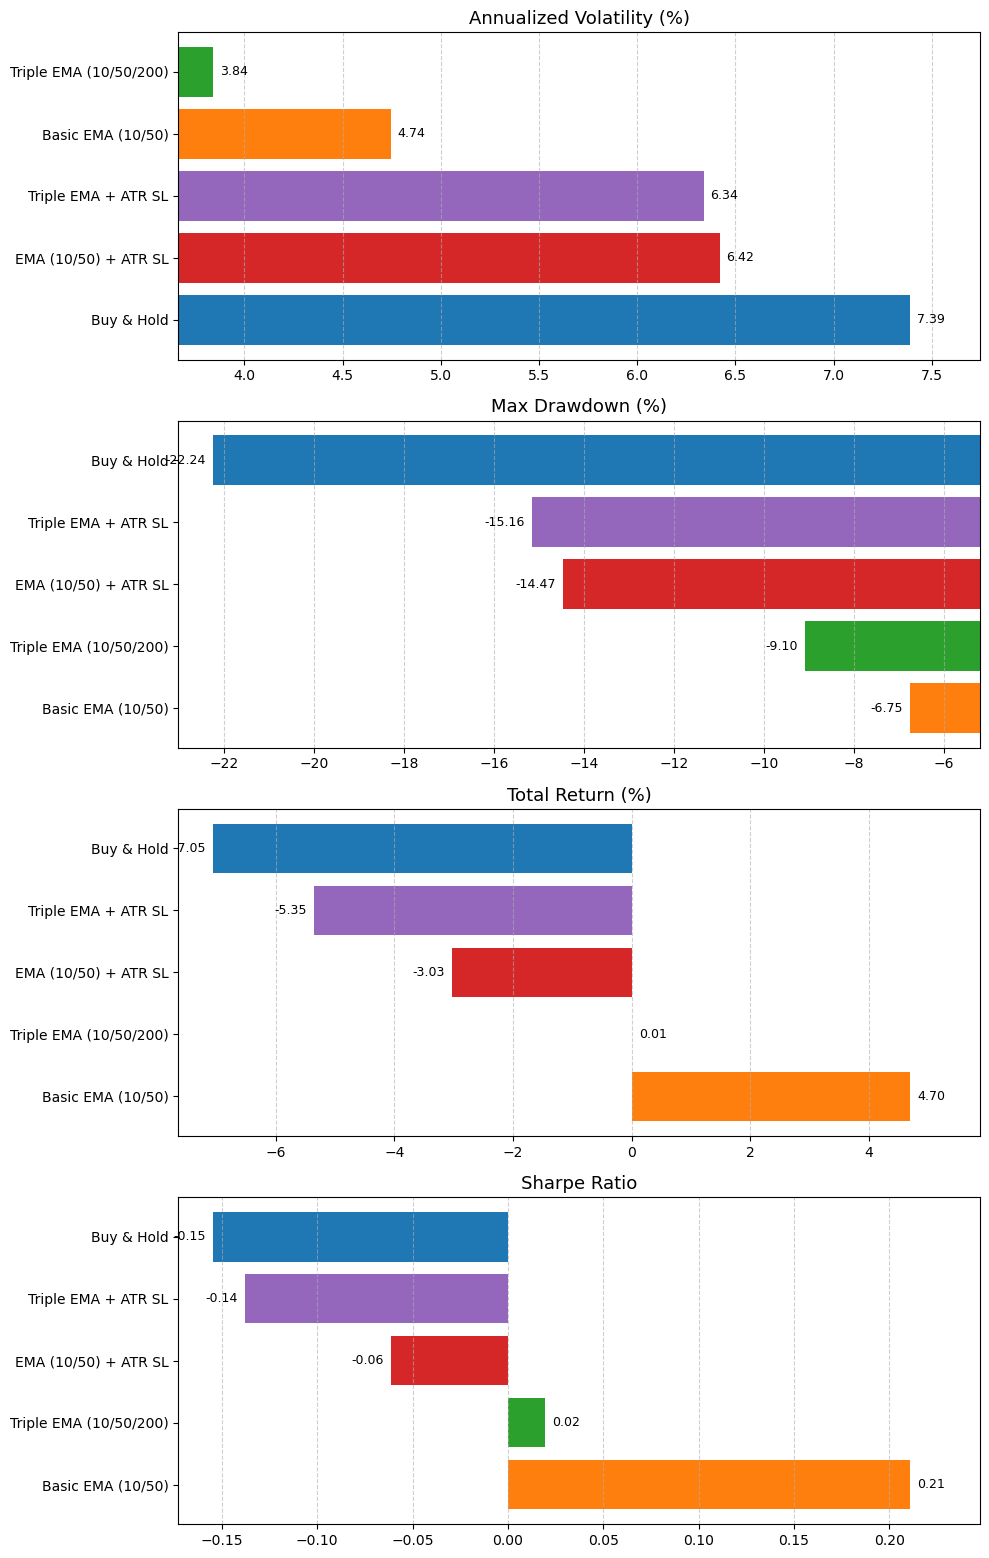

In [3]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# === Setup ===
strategy_names = [
    "Buy & Hold",
    "Basic EMA (10/50)",
    "Triple EMA (10/50/200)",
    "EMA (10/50) + ATR SL",
    "Triple EMA + ATR SL"
]

metrics_files = [
    f"{ticker}_00_metrics.json",
    f"{ticker}_01_metrics.json",
    f"{ticker}_02_metrics.json",
    f"{ticker}_03_metrics.json",
    f"{ticker}_04_metrics.json"
]

strategy_colors = {
    'Buy & Hold': '#1f77b4',
    'Basic EMA (10/50)': '#ff7f0e',
    'Triple EMA (10/50/200)': '#2ca02c',
    'EMA (10/50) + ATR SL': '#d62728',
    'Triple EMA + ATR SL': '#9467bd'
}

# === Load all JSON metrics ===
metrics_list = []
valid_strategies = []
all_keys = []

for name, file in zip(strategy_names, metrics_files):
    path = os.path.join("Outputs", file)
    if not os.path.exists(path):
        print(f"Skipping missing file: {file}")
        continue
    with open(path, "r") as f:
        data = json.load(f)
        metrics_list.append(data)
        valid_strategies.append(name)
        all_keys.append(set(data.keys()))

# === Determine common metrics ===
common_keys = set.intersection(*all_keys)
if not common_keys:
    raise ValueError("No metrics are common to all strategies.")

# === Build filtered DataFrame ===
filtered_metrics = []
for d in metrics_list:
    filtered = {k: float(d[k]) for k in common_keys}
    filtered_metrics.append(filtered)

metrics_df = pd.DataFrame(filtered_metrics, index=valid_strategies)
metrics_df_T = metrics_df.T

# === Plot common metrics only ===
fig, axs = plt.subplots(nrows=len(common_keys), ncols=1, figsize=(10, 4 * len(common_keys)))
if len(common_keys) == 1:
    axs = [axs]

for i, metric in enumerate(metrics_df_T.index):
    values = metrics_df_T.loc[metric].sort_values()
    colors = [strategy_colors.get(name, '#333333') for name in values.index]

    axs[i].barh(values.index, values, color=colors)
    axs[i].set_title(metric, fontsize=13)
    axs[i].invert_yaxis()
    axs[i].grid(True, axis='x', linestyle='--', alpha=0.6)

    # Annotate values
    min_val, max_val = values.min(), values.max()
    range_span = max_val - min_val if max_val != min_val else 1
    axs[i].set_xlim(min_val - 0.05 * range_span, max_val + 0.1 * range_span)

    for idx, val in enumerate(values):
        offset = 0.01 * range_span if val >= 0 else -0.01 * range_span
        ha = 'left' if val >= 0 else 'right'
        axs[i].text(val + offset, idx, f'{val:.2f}', va='center', ha=ha, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(f"Outputs/{ticker}_strategy_comparison_metrics.png", dpi=300, bbox_inches='tight')
plt.show()